## План
Так как мы уже **подготовили данные** с торговой площадки с лотами вторичной недвижимости (квартиры) в европейском мегаполисе,то можно приступить к использованию методов моделирования и анализа данных чобы **определить значимые для цены факторы** этой недвижимости.

**Моделирование:**
* Дополнительная предварительная обработка данных для используемых моделей
    * Кодирование категориальных признаков 
* Моделирование
    * Задача регрессии
    * Схема валидации при подборе параметров: $50%$ отложенной выборки (половина имеющихся на рынке объявлений) со страдификацией по числу комнат
    * Обучение логического алгоритма (градиентный бустинг) на всей доступной выборке (все доступные на рынке объявлений)
    * Анализ построенных деревьев (признаки при построении первых деревьев, суммарное и среднее влияние признаков при подсчете информационного критерия, встречаемость признака в разбиениях; `“gain”, result contains total gains of splits which use the feature and “split”, result contains numbers of times the feature is used in a model`)

* Дополнительный разведывательный анализ данных:
    * Попарные корреляции интересных категориальных признаков
    * Попарные корреляции интересных количественных признаков

**Отчет 2: Влияние факторов на цену за метр у лотов**
* Мы видим, что на нашей выборке самыми значимыми факторами влияющими на **цену предложения на метр^2** в 'обобщенной' Московской квартиры на рынке вторичной недвижимости оказываются **район и метро**. Причем, наибольший информационный вклад на имеющейся выборке вносит именно район, хотя незначительно чуть чаще и для объяснения цены в алгоритме используется метро.
* Также, именно районы и метро встречаются в первых деревьях, и даже узлах деревьев бустинга наиболее часто.
* Далее, **по мощности вклада** следуют возраст дома (также, он обратно связан с количеством этажей), вид ремонта (также, он еще и относительно часто встречается), площадь лота (которая, также, оказывает наибольшее влияние на абсолютную цену квартиры) и количество этажей. С другой стороны, **наиболее часто** в узлах наших деревьев далее встречаются возраст дома, площадь и количество этажей в доме. А так как, количество этажей сильно обратно скорелированно с возрастом дома, то есть, наиболее вероятно, что эти два критерия позволяют модели лучше разделить нашу выборку и уточняют зависимости в данных, а не используются в качестве попарной замены.
* Доля куханной площади вносит относительно высокий вклад, и также часто встречается. В похожей, но менее значимой ситуации находятся этаж и тип дома.
* Также, относительно часто встречаются такие факторы, как доля жилой площади, расстояние до метро, количество комнат (связано с площадью), однако их вклад не велик и вероятно они используются для разделение спорных лотов.

Из интересного, 
* Даже методами описательного анализа можно подвердить вывод из статьи (Магнус, Пересецкий, 2011) о том, что цена за метр в квартирах большей площади возрастает. Также, она возрастает в квартирах с большим числом комнат, и, вероятно, возрастает и в квартирах с большим числом санузлов, потому что наличие более одного санузла сильнее скоррелировано с площадью, чем с количеством комнат
* В зависимости от категории кол-ва комнат лота, значимость признаков может меняться

#### Влияние ветки метро
* Для измерения следует обработать данные по станциям, которые встречаются в более чем одной ветке. Например, станция Третьяковская по данным с портала открытых данных города Москвы ([ссылка](https://data.mos.ru/classifier/7704786030-stantsii-moskovskogo-metropolitena) расположена одновременно на трех ветках, одна из которых еще строится. Доступная выгрузка из источника данных не дает такой подробной информации. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder
import statsmodels
PATH_TO_PROCESSED_DATA = '../data/'
PATH_TO_IMAGES = '../imgs/'

from collections import defaultdict
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import lightgbm as lgbm
import eli5
import scipy.stats

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
df = pd.read_csv(PATH_TO_PROCESSED_DATA + 'features_dataset.csv', index_col=[0])
target = pd.read_csv(PATH_TO_PROCESSED_DATA + 'target_column.csv', index_col=[0])
print(df.shape)
print(f'{df.memory_usage().sum() / 1024 / 1024 :.2f} Mb')
assert df.shape[0] == target.shape[0]

(14329, 25)
1.98 Mb


In [3]:
df.nunique()

Округ                                 12
Район                                153
Площадь                             1736
Площадь лог                         1736
Кол-во комнат                          7
Этаж                                  73
Этажей в доме                         73
Первый этаж                            2
Последний этаж                         2
Метро                                272
Расстояние до метро (ед)              57
Расстояние указано пешком              2
Расстояние указано на транспорте       2
Тип дома                               7
Указан раздельный санузел              2
Несколько санузлов                     2
Балкон указан                          2
Окна                                   3
Окна во двор                           2
Ремонт                                 4
Наличие ремонта                        2
Возраст дома                         126
Доля жилой площади                  6121
Доля куханной площади               5252
Площадь кухни   

### Предобрабатываем

> Закодируем `категориальные признки`: Округ, Район, Метро, Кол-во комнат

In [4]:
df.head(1)

,Округ,Район,Площадь,Площадь лог,Кол-во комнат,Этаж,Этажей в доме,Первый этаж,Последний этаж,Метро,...,Несколько санузлов,Балкон указан,Окна,Окна во двор,Ремонт,Наличие ремонта,Возраст дома,Доля жилой площади,Доля куханной площади,Площадь кухни
0,ВАО,р-н Гольяново,33.0,3.496508,1,9.0,9.0,False,True,Первомайская,...,False,False,Во двор,True,Без ремонта,False,51.0,0.484848,0.212121,7.0


In [5]:
logging.info(f'Предобрабатываем: {df.columns[df.dtypes == "object"].values.tolist()}.')
label_encoder_dict = defaultdict(LabelEncoder)

# допустим, что это в функции
df['Округ'] = df['Округ'].astype(str)
df['Район'] = df['Район'].astype(str)
df['Кол-во комнат'] = df['Кол-во комнат'].astype(str)
df['Метро'] = df['Метро'].astype(str)
df['Тип дома'] = df['Тип дома'].astype(str)
df['Окна'] = df['Окна'].astype(str)
df['Ремонт'] = df['Ремонт'].astype(str)

# df['Доля жилой площади'] = df['Доля жилой площади'].fillna(df.groupby('Кол-во комнат')['Доля жилой площади'].transform('median'))
# pd.get_dummies(df, columns=['Кол-во комнат', 'Метро', 'Тип дома', 'Окна', 'Ремонт'])
# df['Площадь'] = np.log(df['Площадь'])

cat_columns = df.columns[df.dtypes == 'object']
df[cat_columns] = df[cat_columns].apply(lambda x: label_encoder_dict[x.name].fit_transform(x)).astype('category')
# label_encoder_dict['Округ'].inverse_transform([8])
# df[cat_columns].apply(lambda x: label_encoder_dict[x.name].inverse_transform(x))

logging.info(f'Предобработка: завершение')

INFO:root:Предобрабатываем: ['Округ', 'Район', 'Кол-во комнат', 'Метро', 'Тип дома', 'Окна', 'Ремонт'].
INFO:root:Предобработка: завершение


### Моделируем

> Зависимость `цены за метр^2` от признаков лотов (независимо от кол-ва комнат)

In [6]:
def metrics_report(y_pred : np.array, y_true : np.array):
    '''
    Вывод метрик качества и графика рассеивания
    :input:
        predicted and background truth targets
    :return: 
        R2 and Mean Absolute Errors metrics values
    '''
    r2 = sklearn.metrics.r2_score(y_pred, y_true)
    mae = sklearn.metrics.mean_absolute_error(y_pred, y_true)
    mse = sklearn.metrics.mean_squared_error(y_pred, y_true)
    
    plt.scatter(y=y_pred, x=y_true, alpha=0.25);
    plt.ylabel('predicted log(Цена за метр^2)')
    plt.xlabel('log(Цена за метр^2)')
    plt.title('Диаграмма рассеивания (log(ˆp), log(p))')
    
    logging.info(f'R2 = {r2:.2f}; MAE = {mae:.2f}; MSE = {mse:.2f}')
    return r2, mae, mse

In [7]:
cols_not_to_use = ['Площадь', 'Площадь кухни']
target_col = 'Цена за метр^2'

logging.info(f'Моделируем: {target_col}.')
logging.info(f'Не используем: {cols_not_to_use}.')
logging.info(f'Используем: {list(df.columns[~df.columns.isin(cols_not_to_use)])}.')

INFO:root:Моделируем: Цена за метр^2.
INFO:root:Не используем: ['Площадь', 'Площадь кухни'].
INFO:root:Используем: ['Округ', 'Район', 'Площадь лог', 'Кол-во комнат', 'Этаж', 'Этажей в доме', 'Первый этаж', 'Последний этаж', 'Метро', 'Расстояние до метро (ед)', 'Расстояние указано пешком', 'Расстояние указано на транспорте', 'Тип дома', 'Указан раздельный санузел', 'Несколько санузлов', 'Балкон указан', 'Окна', 'Окна во двор', 'Ремонт', 'Наличие ремонта', 'Возраст дома', 'Доля жилой площади', 'Доля куханной площади'].


In [8]:
regressor = lgbm.LGBMRegressor(max_depth=7, n_estimators=100,
                               num_leaves=12, reg_alpha=1.1, reg_beta=0.1,
                               importance_type='split', 
                               random_state=42)

Посмотрим на метрики качества (насколько хорошо наш алгоритм может объяснить имеющиеся данные)

INFO:root:R2 = 0.87; MAE = 0.10; MSE = 0.02


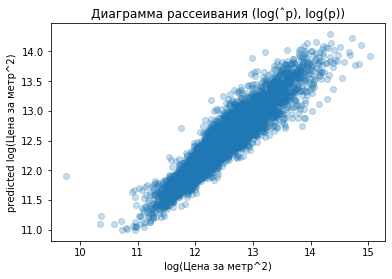

In [9]:
regressor.fit(df.iloc[:, ~df.columns.isin(cols_not_to_use)], 
              np.log(target[target_col].values));
metrics_report(regressor.predict(df.iloc[:, ~df.columns.isin(cols_not_to_use)]),
               np.log(target[target_col].values));

Посмотрим на относительные ошибки

In [10]:
z = np.exp(regressor.predict(df.iloc[:, ~df.columns.isin(cols_not_to_use)])) - target[target_col].values
z = abs(z) / target[target_col].values
z = pd.DataFrame(z, index=df.iloc[:, ~df.columns.isin(cols_not_to_use)].index, columns=['Ошибка'])
z['Кол-во комнат'] = df['Кол-во комнат']
z['Площадь'] = df['Площадь']

z.groupby('Кол-во комнат')['Ошибка'].quantile(0.8)

Кол-во комнат
0    0.108209
1    0.144826
2    0.162969
3    0.197240
4    0.258064
5    0.351969
6    0.144068
Name: Ошибка, dtype: float64

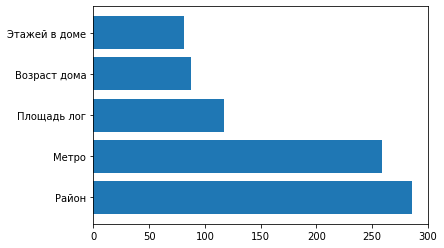

In [11]:
y = df.iloc[:, ~df.columns.isin(cols_not_to_use)].columns[regressor.feature_importances_.argsort()[::-1][:5]]
x = regressor.feature_importances_[regressor.feature_importances_.argsort()[::-1][:5]]
plt.barh(width=x, y=y);

In [12]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='gain')

Weight,Feature
0.6844,Район
0.1650,Метро
0.0419,Возраст дома
0.0283,Ремонт
0.0277,Площадь лог
0.0219,Этажей в доме
0.0120,Доля куханной площади
0.0048,Этаж
0.0044,Тип дома
0.0025,Доля жилой площади


In [13]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.2600,Район
0.2355,Метро
0.1064,Площадь лог
0.0800,Возраст дома
0.0736,Этажей в доме
0.0473,Этаж
0.0418,Доля куханной площади
0.0409,Ремонт
0.0200,Тип дома
0.0164,Наличие ремонта


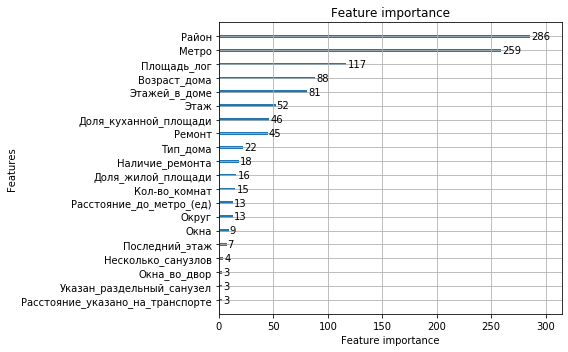

In [14]:
lgbm.plot_importance(regressor, figsize=(8, 5))
plt.tight_layout();

**Вывод:** значения метрик высоки, но 
1. доминирующий вклад вносят от 1-2 до 2-6 признаков
2. метрика качества при такой валидации означает лишь то, насколько хорошо алгоритм смог выучить имеющиеся данные и их закономерности (при определенной трактовке задачи этого может быть достаточно, но на всякий случай проведем валидацию на отложенной выборке, а заодно и более регуляризуем наш алгоритм)

### Посмотрим на более регуляризованную модель, на половине выборки и с разбиением по количеству комнат
> * То есть, мы моделируем ситуацию, когда у нас было ~7000 лотов, а потом пришло еще 7000 тысяч, с примерным сохранением количества комнат*, и мы хотим узнать, насколько хорошо наша модель может объяснить цену на них.  
* Проблемой такого подхода может быть недостаточное количество наблюдений по категориям чтобы построить хорошую модель на них


\* Да, мы знаем, что как минимум раз за 10 лет это распределение сдвигается, на основе статьи (Магнус, Пересецкий), но за 10 лет могут происходить куда более серьезные с точки зрения нашей модели изменения, чем лишь изменение количества комнат в лотах. Например, рост цен в несколько раз относительно цен на которых мы моделировали значимости.

In [15]:
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(df.iloc[:, ~df.columns.isin(cols_not_to_use)], 
                                                                              np.log(target[target_col]), 
                                                                              test_size = 0.5, 
                                                                              shuffle = True, 
                                                                              stratify = df['Кол-во комнат'], 
                                                                              random_state = 891)
train_data = lgbm.Dataset(train_x, label=train_y)
valid_data = lgbm.Dataset(valid_x, label=valid_y)

In [16]:
params = {'metric' : 'mse',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 12,
          'max_depth' : 7,
          'n_estimators' : 500,
          'min_child_samples': 399, 
          'min_child_weight': 0.1,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.855,
          'verbose' : 100,
          'learning_rate' : 0.1,
          'num_threads' : 2}

In [17]:
#Train model on selected parameters and number of iterations
regressor_2 = lgbm.train(params,
                 train_data,
                 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 120,
                 verbose_eval = 500
                 )
regressor_2.booster_ = regressor_2

D:\Anaconda\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 120 rounds.
[500]	valid_0's l2: 0.0310352
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.0310352


Посмотрим на метрики качества (насколько хорошо наш, но чуть более строгий алгоритм, мог бы объяснить 'новые' данные с такой же природой)

INFO:root:R2 = 0.83; MAE = 0.12; MSE = 0.03


(0.8258092739192744, 0.11819142616161729, 0.03103521729349717)

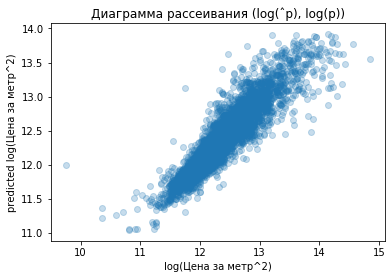

In [18]:
metrics_report(regressor_2.predict(valid_x), valid_y)

Относительные ошибки

In [19]:
z = np.exp(regressor_2.predict(valid_x)) - np.exp(valid_y)
z = abs(z) / np.exp(valid_y)
z = pd.DataFrame(z)
z['Кол-во комнат'] = valid_x['Кол-во комнат']
z['Площадь'] = valid_x['Площадь лог']

z.groupby('Кол-во комнат')['Цена за метр^2'].quantile(0.9)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Кол-во комнат
0    0.169682
1    0.213519
2    0.253620
3    0.302682
4    0.351130
5    0.554663
6    0.219066
Name: Цена за метр^2, dtype: float64

In [20]:
eli5.explain_weights_lightgbm(regressor_2, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='gain')

Weight,Feature
0.7068,Район
0.1497,Метро
0.0334,Возраст дома
0.0234,Ремонт
0.0224,Площадь лог
0.0158,Доля куханной площади
0.0141,Этажей в доме
0.0092,Округ
0.0061,Кол-во комнат
0.0049,Этаж


In [21]:
eli5.explain_weights_lightgbm(regressor_2, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.2871,Район
0.2385,Метро
0.0676,Возраст дома
0.0619,Площадь лог
0.0517,Доля куханной площади
0.0452,Этажей в доме
0.0399,Доля жилой площади
0.0397,Округ
0.0360,Ремонт
0.0297,Кол-во комнат


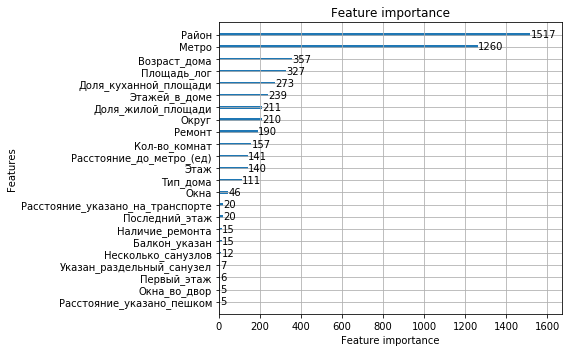

In [22]:
lgbm.plot_importance(regressor_2, importance_type='split', figsize=(8, 5))
plt.tight_layout()

**Вывод:** значения метрик ожидаемо стали хуже (например, R^2 упал, значение метрики относительной ошибки прогноза выросло), но 
1. модель теперь более регуляризована по признакам и искусственно недостигает точки остановы по критерию отсутствия изменения метрики качества (для этого нужно добавить деревьев, но увеличить риск уменьшения обобщающей спобосности)
2. мы не контроллировали разбиения по другим категориальным признакам, только по числу комнат, это может быть и вероятно есть критично для данных этой структуры (высокое количество районов, высокое количество пропусков в некоторых полях) 
3. самые значимые признаки всё равно остаются неизменными.

### Рассмотрим связи признаков после моделирования

> Посмотрим на связь признаков
* Корреляции Пирсона для количественным и Спирмана для качественных

* *Логорифм от площади взят, чтобы сгладить выбросы цены на графике и не удалять их*

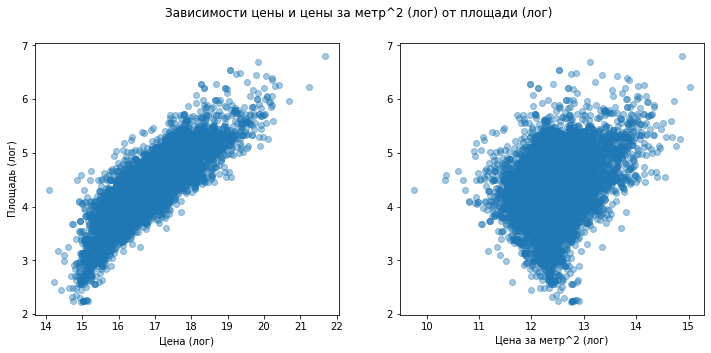

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Зависимости цены и цены за метр^2 (лог) от площади (лог)')
ax[0].scatter(x=np.log(target['Цена'].values), y=np.log(df['Площадь'].values), alpha=0.4)
ax[1].scatter(x=np.log(target['Цена за метр^2'].values), y=np.log(df['Площадь'].values), alpha=0.4)

ax[0].set_ylabel('Площадь (лог)')
ax[0].set_xlabel('Цена (лог)')
ax[1].set_xlabel('Цена за метр^2 (лог)')


plt.savefig(PATH_TO_IMAGES + 'Цена на метр^2 от площади')

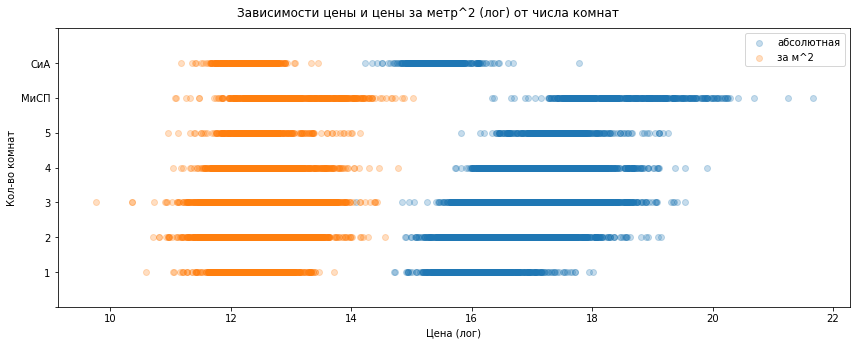

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Зависимости цены и цены за метр^2 (лог) от числа комнат')
ax.scatter(x=np.log(target['Цена'].values), y=df['Кол-во комнат'].values, alpha=0.25, label='абсолютная')
ax.scatter(x=np.log(target['Цена за метр^2'].values), y=df['Кол-во комнат'].values, alpha=0.25, label='за м^2')
#plt.scatter(x=np.log(target['Цена за метр^2'].values), y=df['Кол-во комнат'].values, alpha=0.4)
ticks = [label_encoder_dict['Кол-во комнат'].inverse_transform([int(tick)])[0] for tick in plt.yticks()[0].tolist()[1:-1]]
plt.yticks(plt.yticks()[0], [''] + ticks + ['']);

ax.set_ylabel('Кол-во комнат')
ax.set_xlabel('Цена (лог)');
plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(PATH_TO_IMAGES + 'Цены и число комнат (точки)')

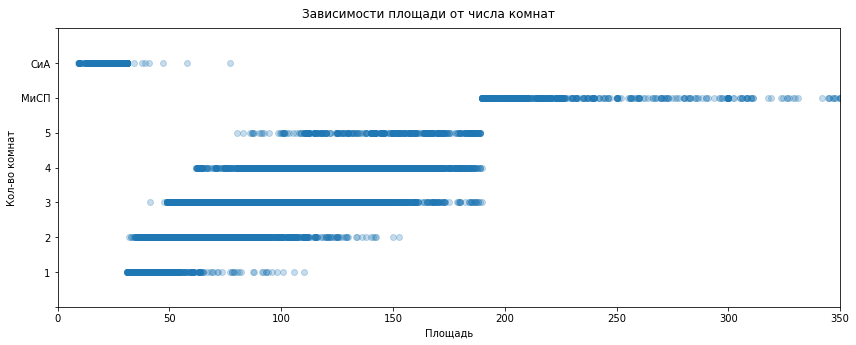

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Зависимости площади от числа комнат')
ax.scatter(x=df['Площадь'].values, y=df['Кол-во комнат'].values, alpha=0.25)
ticks = [label_encoder_dict['Кол-во комнат'].inverse_transform([int(tick)])[0] for tick in plt.yticks()[0].tolist()[1:-1]]
plt.yticks(plt.yticks()[0], [''] + ticks + ['']);
ax.set_ylabel('Кол-во комнат')
ax.set_xlabel('Площадь');
ax.set_xlim(0, 350)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(PATH_TO_IMAGES + 'Площадь и число комнат (точки)')

Интересные характеристики лотов
* Наличие более одного санузла, сильнее связано с площадью, чем с количеством комнат. А площадь уже связано с количеством комнат.
* Число этажей обратно пропорционально возрасту дома. Наверное, это ожидаемо, при учете медианного возраста дома в $20$ лет ($18$ без обработки пропусков), а медианного количества этажей в доме равного $16$

In [26]:
scipy.stats.spearmanr(df['Кол-во комнат'].values, df['Несколько санузлов'].values)

SpearmanrResult(correlation=0.2723271747586393, pvalue=4.587435724451326e-242)

In [27]:
scipy.stats.spearmanr(df['Площадь'].values, df['Несколько санузлов'].values)

SpearmanrResult(correlation=0.5148898159125749, pvalue=0.0)

In [28]:
scipy.stats.spearmanr(df['Площадь'].values, df['Кол-во комнат'].values)

SpearmanrResult(correlation=0.6047449898902657, pvalue=0.0)

In [29]:
scipy.stats.spearmanr(df['Этажей в доме'].values,
                      df['Возраст дома'].fillna(df.groupby(['Кол-во комнат'])['Возраст дома'].transform('median')))

SpearmanrResult(correlation=-0.5032993608981183, pvalue=0.0)

* Район сильнее связан как с абсолютной ценой, так и с ценой за метр квадратный, чем округ

In [30]:
df['Возраст дома'].fillna(df.groupby('Кол-во комнат')['Возраст дома'].transform('median')).values

array([51., 57., 52., ..., 16., 14., 14.])

In [31]:
scipy.stats.spearmanr(df['Район'].values, target.astype(int)['Цена'].values)

SpearmanrResult(correlation=0.29927339405128434, pvalue=2.684018004584051e-294)

In [32]:
scipy.stats.spearmanr(df['Метро'].values, target.astype(int)['Цена'].values)

SpearmanrResult(correlation=0.09587336239647344, pvalue=1.2903323021515915e-30)

* По не ясной причине, доля куханной площади обратно пропорционально площади. Возможно, дело в количестве пропусков и том, что мы не имеем полной картины 

In [33]:
np.corrcoef(df['Площадь'].values, 
            df['Доля жилой площади'].fillna(df.groupby('Кол-во комнат')['Доля жилой площади'].transform('median')))

array([[1.       , 0.1679089],
       [0.1679089, 1.       ]])

In [34]:
np.corrcoef(df['Площадь'].values, 
            df['Доля куханной площади'].fillna(df.groupby('Кол-во комнат')['Доля куханной площади'].transform('median')))

array([[ 1.        , -0.43344788],
       [-0.43344788,  1.        ]])

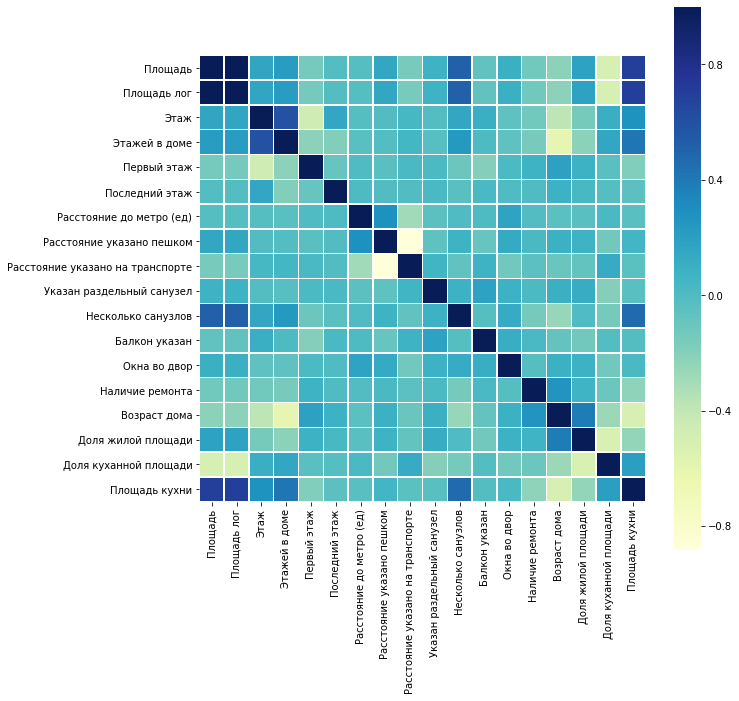

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(method='spearman'), linewidth=0.5, square=True,  cmap="YlGnBu")

plt.savefig(PATH_TO_IMAGES + 'Матрица корреляции признаков')

> Посмотрим на еще один способ изучить значимость признаков
* SHAP

In [36]:
import shap

Wall time: 0 ns


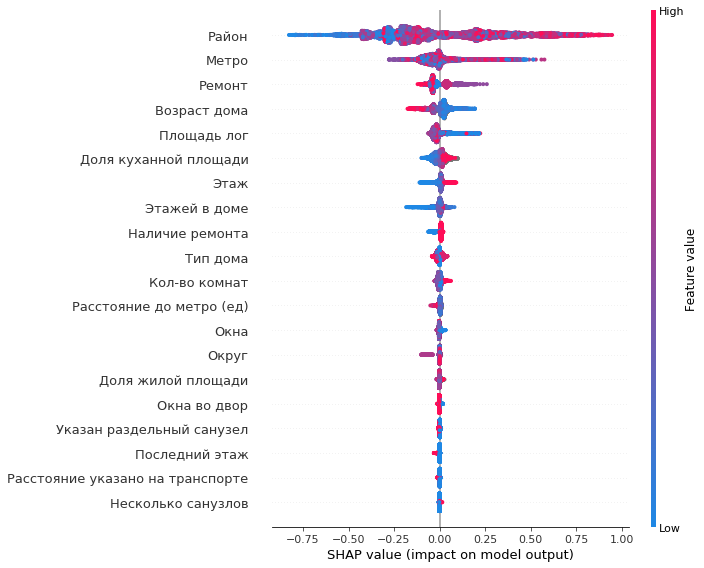

In [37]:
%time
# https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
# https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(df.iloc[:, ~df.columns.isin(cols_not_to_use)])
shap.summary_plot(shap_values, df.iloc[:, ~df.columns.isin(cols_not_to_use)])

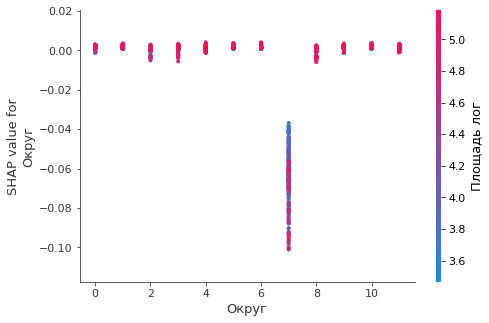

In [38]:
shap.dependence_plot("Округ", shap_values, df.iloc[:, ~df.columns.isin(cols_not_to_use)])

А так можно посмотреть на вклад в каждый отдельный лот

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0:1], 
                df.iloc[:, ~df.columns.isin(cols_not_to_use)][0:1])

In [40]:
df.iloc[:, :][0:1]

,Округ,Район,Площадь,Площадь лог,Кол-во комнат,Этаж,Этажей в доме,Первый этаж,Последний этаж,Метро,...,Несколько санузлов,Балкон указан,Окна,Окна во двор,Ремонт,Наличие ремонта,Возраст дома,Доля жилой площади,Доля куханной площади,Площадь кухни
0,0,53,33.0,3.496508,0,9.0,9.0,False,True,159,...,False,False,1,True,1,False,51.0,0.484848,0.212121,7.0


In [41]:
label_encoder_dict['Кол-во комнат'].inverse_transform([0])

array(['1'], dtype=object)

In [42]:
label_encoder_dict['Ремонт'].inverse_transform([1])

array(['Без ремонта'], dtype=object)

In [43]:
label_encoder_dict['Район'].inverse_transform([53])

array(['р-н Гольяново'], dtype=object)

In [44]:
label_encoder_dict['Метро'].inverse_transform([159])

array(['Первомайская'], dtype=object)